In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import torch


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "SPY.csv"
df = pd.read_csv(file_path)




# start to nov 2001 (dot com crash)
# not bad
# df = df.iloc[:2228]

# nov 01 to june 2009
# not bad
# df = df.iloc[2228:4135]

# june 2009 to april 2020
# ass
df = df.iloc[4135:6862]

# april 2020 to most recent
# ass
# df = df.iloc[6862:]


# Convert the "Date" column to datetime
# df["Date"] = pd.to_datetime(df["Date"], format='%Y/%m/%d')

# # Sort the data by date in ascending order
# df = df.sort_values(by="Date")

# # Get the earliest and latest dates
# earliest_date = df["Date"].min()
# latest_date = df["Date"].max()

# print("Earliest Date:", earliest_date)
# print("Latest Date:", latest_date)


In [32]:
print(df.tail())

            Date        Open        High         Low       Close     Volume  \
6857  2020-04-23  262.458644  265.686871  260.830509  261.139282  104709700   
6858  2020-04-24  262.683183  265.462257  260.596529  264.779175   85063200   
6859  2020-04-27  266.791031  269.738528  266.323174  268.596954   77896600   
6860  2020-04-28  272.311790  272.667366  267.053075  267.361877  105270000   
6861  2020-04-29  272.788998  275.923649  271.741002  274.360992  118745600   

      Day  Weekday  Week  Month  Year  
6857   23        3    17      4  2020  
6858   24        4    17      4  2020  
6859   27        0    18      4  2020  
6860   28        1    18      4  2020  
6861   29        2    18      4  2020  


In [33]:
# if 'Day' and 'Weekday' and 'Week' and 'Month' and 'Year' in df.columns:
    # df.drop(columns=['Day', 'Weekday', 'Week', 'Month', 'Year'], inplace=True)

In [34]:
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)


In [35]:
df = df.dropna()

In [36]:
# Adding SMA as part of the feature test
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean()
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean()
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean()

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA


In [37]:
df = df.dropna()

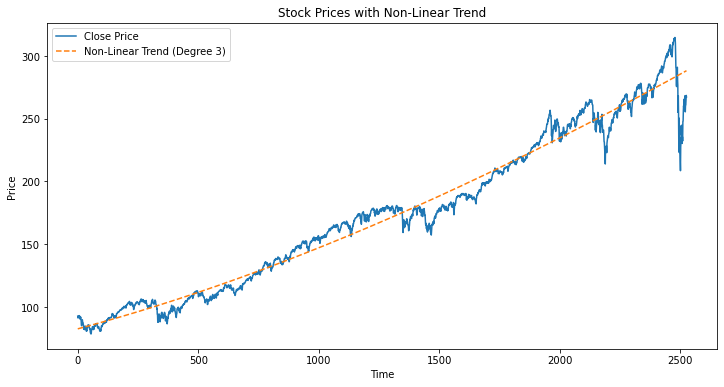

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Assuming you have a DataFrame `df` with a 'Close' column

# Create an index for the time series (usually the row number)
df['Time'] = np.arange(len(df))

# Fit a polynomial regression to the 'Close' price
X = df[['Time']]  # Independent variable (time)
y = df['Close']   # Dependent variable (closing price)

# Initialize a polynomial features transformer (degree = 2 for quadratic, or higher for more non-linearity)
degree = 3  # You can change the degree for more complexity
poly = PolynomialFeatures(degree)

# Transform the Time feature into polynomial features
X_poly = poly.fit_transform(X)

# Initialize and fit the linear regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly, y)

# Generate predictions for the polynomial regression (non-linear trend)
df['Non_Linear_Trend'] = model.predict(X_poly)

# Optionally, visualize the non-linear trend
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Close'], label='Close Price')
plt.plot(df['Time'], df['Non_Linear_Trend'], label=f'Non-Linear Trend (Degree {degree})', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Prices with Non-Linear Trend')
plt.legend()
plt.show()

## CREATING THE NEURAL NETWORK MODEL

In [39]:
dates = df["Date"]
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [41]:
# Define the LSTM-based model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        out = self.fc(out)  # Shape: (batch_size, 1)
        out = self.sigmoid(out)
        return out

# Define a more complex LSTM-based model
# class ComplexLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
#         super(ComplexLSTMModel, self).__init__()
#         # LSTM Layer: Bidirectional for richer context
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
#                             batch_first=True, dropout=dropout_rate,
#                             bidirectional=True)
#         # Fully connected layers for added complexity
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM doubles hidden size
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size // 2, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # LSTM expects input of shape (batch_size, sequence_length, input_size)
#         out, _ = self.lstm(x)
#         # Use the output of the last time step
#         out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
#         out = self.fc1(out)  # First fully connected layer
#         out = self.dropout1(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc2(out)  # Second fully connected layer
#         out = self.dropout2(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc3(out)  # Output layer
#         out = self.sigmoid(out)  # Apply sigmoid for binary classification
#         return out

# class ComplexLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
#         super(ComplexLSTMModel, self).__init__()
#         # LSTM Layer: Bidirectional for richer context
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
#                             batch_first=True, dropout=dropout_rate,
#                             bidirectional=True)
#         # Fully connected layers for added complexity
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM doubles hidden size
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size // 2, 1)

#     def forward(self, x):
#         # LSTM expects input of shape (batch_size, sequence_length, input_size)
#         out, _ = self.lstm(x)
#         # Use the output of the last time step
#         out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
#         out = self.fc1(out)  # First fully connected layer
#         out = self.dropout1(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc2(out)  # Second fully connected layer
#         out = self.dropout2(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc3(out)  # Output layer
#         return out

class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # Unidirectional LSTM for sequential stock price prediction
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)  # Removed bidirectional=True

        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = torch.relu(self.fc1(out))  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))  # Second fully connected layer
        out = self.dropout2(out)
        out = self.fc3(out)  # Output layer (no activation for regression)
        return out


In [42]:

sequence_length = 10

# Reshape data into sequences
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)


In [43]:

# scaler = StandardScaler()
# scaler = MinMaxScaler()
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Day", "Weekday", "Week", "Month", "Year"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200", "Non_Linear_Trend"]
feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend", "SMA_20", "SMA_50", "EMA_10", "EMA_50"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend"]

# Split data
train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

# Initialize scaler
# scaler = RobustScaler()
scaler = MinMaxScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

# scaler = StandardScaler()

# scaler.fit(X_train)
# X_scaled = pd.DataFrame(scaler.fit_transform(X[feature_columns]), columns=feature_columns, index=X.index)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)


# Split sequentially
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 1768, Val: 379, Test: 370


In [44]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [45]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0005
num_epochs = 500
patience = 30


# Initialize the LSTM model
# model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)
model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)

model.to(device)

# Define loss and optimizer
# criterion = nn.BCELoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
best_val_loss = float('inf')
early_stop_counter = 0

# if not os.path.exists("./models/best_lstm_model.pth"):
if not os.path.exists("./lstm_trials/lstm_after_gridsearch_new.pth"):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.unsqueeze(1)  # Match output shape
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch = y_batch.unsqueeze(1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), "./lstm_trials/lstm_after_gridsearch_new.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

# Load the best model
# model.load_state_dict(torch.load("./lstm_trials/lstm_after_gridsearch_new.pth"))

# Evaluate on test data
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

# Calculate Mean Absolute Error (MAE)
test_mae = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))
        test_mae += mae.item() * X_batch.size(0)

test_mae /= len(test_loader.dataset)
print(f'Test MAE: {test_mae:.4f}')


Epoch 1/500, Train Loss: 21180.3228, Val Loss: 55871.4824
Epoch 2/500, Train Loss: 20088.8273, Val Loss: 52903.9440
Epoch 3/500, Train Loss: 17772.7631, Val Loss: 47845.8932
Epoch 4/500, Train Loss: 14432.7729, Val Loss: 40854.0986
Epoch 5/500, Train Loss: 10406.3379, Val Loss: 32392.2425
Epoch 6/500, Train Loss: 6362.4176, Val Loss: 23095.7617
Epoch 7/500, Train Loss: 3122.5405, Val Loss: 13854.6634
Epoch 8/500, Train Loss: 1706.7227, Val Loss: 9209.3905
Epoch 9/500, Train Loss: 1591.0883, Val Loss: 10236.0177
Early stopping counter: 1/30
Epoch 10/500, Train Loss: 1351.7121, Val Loss: 8022.3267
Epoch 11/500, Train Loss: 412.5616, Val Loss: 2758.8060
Epoch 12/500, Train Loss: 296.9861, Val Loss: 1772.6031
Epoch 13/500, Train Loss: 278.9482, Val Loss: 1620.0752
Epoch 14/500, Train Loss: 260.2029, Val Loss: 1412.2727
Epoch 15/500, Train Loss: 269.9484, Val Loss: 1267.9891
Epoch 16/500, Train Loss: 265.0386, Val Loss: 1260.1144
Epoch 17/500, Train Loss: 257.4491, Val Loss: 890.6321
Epoch 

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [46]:
# X_seq_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_seq_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# outputs = model(X_seq_tensor)

# error = 0
# largest_error = 0
# less_than_actual = 0
# more_than_actual = 0

# for true, pred in zip(y_test, outputs):
#     percent = abs(true - pred) / true
#     if percent > largest_error:
#         largest_error = percent
#     error += percent
#     if pred < true:
#         less_than_actual += 1
#     else:
#         more_than_actual += 1

# error = error / len(y_test)
# error = error.item()
# largest_error = largest_error.item()
# print(f"Average error percentage: {error*100}")
# print(f"Largest error percentage: {largest_error*100}")
# print(f"Less than actual: {less_than_actual}")
# print(f"More than actual: {more_than_actual}")



In [47]:

# plt.figure(figsize=(12, 6))
# plt.plot(y_test, label='True Values')
# plt.plot(outputs.cpu().detach().numpy(), label='Predicted Values')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('True vs Predicted Values')
# plt.legend()
# plt.show()

## Evaluating on entire dataset

In [48]:
# X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
# y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32).to(device)

# outputs = model(X_seq_tensor)


In [49]:
# error = 0
# largest_error = 0
# less_than_actual = 0
# more_than_actual = 0

# for true, pred in zip(y_seq, outputs):
#     percent = abs(true - pred) / true
#     if percent > largest_error:
#         largest_error = percent
#     error += percent
#     if pred < true:
#         less_than_actual += 1
#     else:
#         more_than_actual += 1

# error = error / len(y_seq)
# error = error.item()
# largest_error = largest_error.item()
# print(f"Average error percentage: {error*100}")
# print(f"Largest error percentage: {largest_error*100}")
# print(f"Less than actual: {less_than_actual}")
# print(f"More than actual: {more_than_actual}")


In [50]:
# train_cutoff = int(len(y_seq) * 0.7)
# val_cutoff = int(len(y_seq) * 0.85)

# plt.figure(figsize=(12, 6))
# plt.plot(y_seq, label='True Values')
# plt.plot(outputs.cpu().detach().numpy(), label='Predicted Values')
# plt.axvline(x=train_cutoff, color='g', linestyle='--', label='Train/Val Split (80%)')
# plt.axvline(x=val_cutoff, color='b', linestyle='--', label='Val/Test Split (90%)')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('True vs Predicted Values')
# plt.legend()
# plt.show()

In [51]:
# outputs

In [52]:
# df['Target_Higher_Lower'] = np.where(df['Target'] > df['Open'], 'higher', 'lower')

In [53]:
# # Ensure outputs is detached from the computation graph and converted to numpy
# predicted_values = outputs.cpu().detach().numpy()

# # Add the predicted values as a new column in the dataframe
# df['Predicted'] = np.nan
# df.loc[df.index[-len(predicted_values):], 'Predicted'] = predicted_values

# print(df[['Date', 'Target', 'Predicted']].tail())

In [54]:
new_df = df.dropna()

In [55]:
# new_df['Predicted_Higher_Lower'] = np.where(new_df['Predicted'] > new_df['Open'], 'higher', 'lower')
# new_df['Correct'] = np.where(new_df['Predicted_Higher_Lower'] == new_df['Target_Higher_Lower'], 1, 0)

# print('number of correct predictions:', new_df['Correct'].sum())


===== Trial 1 =====
Epoch 1/500, Train Loss: 21292.0498, Val Loss: 56124.9863
Epoch 2/500, Train Loss: 20360.6085, Val Loss: 53725.1087
Epoch 3/500, Train Loss: 18528.4171, Val Loss: 49653.8105
Epoch 4/500, Train Loss: 15721.7394, Val Loss: 43672.0742
Epoch 5/500, Train Loss: 11911.6355, Val Loss: 35222.2757
Epoch 6/500, Train Loss: 7377.0113, Val Loss: 24900.6621
Epoch 7/500, Train Loss: 3461.9984, Val Loss: 14399.5679
Epoch 8/500, Train Loss: 1675.1801, Val Loss: 8279.1187
Epoch 9/500, Train Loss: 1608.5318, Val Loss: 10282.8753
Epoch 10/500, Train Loss: 1506.6234, Val Loss: 9092.4635
Epoch 11/500, Train Loss: 717.3575, Val Loss: 4331.9206
Epoch 12/500, Train Loss: 307.3711, Val Loss: 2052.2475
Epoch 13/500, Train Loss: 283.1849, Val Loss: 1816.4282
Epoch 14/500, Train Loss: 245.0072, Val Loss: 1174.0631
Epoch 15/500, Train Loss: 251.3923, Val Loss: 1156.3262
Epoch 16/500, Train Loss: 273.2465, Val Loss: 1053.8139
Epoch 17/500, Train Loss: 257.6940, Val Loss: 1051.0784
Epoch 18/500,

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 21260.6253, Val Loss: 55827.6230
Epoch 2/500, Train Loss: 19934.3255, Val Loss: 52540.0267
Epoch 3/500, Train Loss: 17585.9468, Val Loss: 47461.1491
Epoch 4/500, Train Loss: 14281.2633, Val Loss: 40703.4372
Epoch 5/500, Train Loss: 10394.3319, Val Loss: 32342.3763
Epoch 6/500, Train Loss: 6319.5081, Val Loss: 22936.3447
Epoch 7/500, Train Loss: 3070.9587, Val Loss: 13429.4036
Epoch 8/500, Train Loss: 1660.4034, Val Loss: 9315.2339
Epoch 9/500, Train Loss: 1557.6092, Val Loss: 9685.2314
Epoch 10/500, Train Loss: 1582.7929, Val Loss: 9502.8483
Epoch 11/500, Train Loss: 851.7518, Val Loss: 5496.8620
Epoch 12/500, Train Loss: 304.6390, Val Loss: 2021.7455
Epoch 13/500, Train Loss: 265.3305, Val Loss: 1382.9991
Epoch 14/500, Train Loss: 270.1658, Val Loss: 1161.1343
Epoch 15/500, Train Loss: 255.7370, Val Loss: 865.1256
Epoch 16/500, Train Loss: 261.8792, Val Loss: 1041.6326
Epoch 17/500, Train Loss: 283.4147, Val Loss: 1022.4185
Epoch 18/500, Train Loss: 262.9176, 

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 21208.5377, Val Loss: 55838.1654
Epoch 2/500, Train Loss: 19916.1943, Val Loss: 52076.0143
Epoch 3/500, Train Loss: 16979.2717, Val Loss: 45654.5482
Epoch 4/500, Train Loss: 12825.2059, Val Loss: 37022.6475
Epoch 5/500, Train Loss: 8231.9431, Val Loss: 26800.4811
Epoch 6/500, Train Loss: 3997.8214, Val Loss: 16061.8955
Epoch 7/500, Train Loss: 1722.6513, Val Loss: 8637.6455
Epoch 8/500, Train Loss: 1587.9997, Val Loss: 10195.2228
Epoch 9/500, Train Loss: 1338.8502, Val Loss: 8025.1027
Epoch 10/500, Train Loss: 380.7674, Val Loss: 2498.9154
Epoch 11/500, Train Loss: 232.3039, Val Loss: 1516.6311
Epoch 12/500, Train Loss: 205.8707, Val Loss: 1317.9003
Epoch 13/500, Train Loss: 232.9628, Val Loss: 1214.7889
Epoch 14/500, Train Loss: 222.0229, Val Loss: 1336.2816
Epoch 15/500, Train Loss: 208.4178, Val Loss: 1027.2724
Epoch 16/500, Train Loss: 198.1537, Val Loss: 995.5339
Epoch 17/500, Train Loss: 215.5957, Val Loss: 1072.2844
Epoch 18/500, Train Loss: 229.6011, Va

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 21266.9766, Val Loss: 56285.0436
Epoch 2/500, Train Loss: 20560.8077, Val Loss: 54224.3958
Epoch 3/500, Train Loss: 18925.4710, Val Loss: 50475.8275
Epoch 4/500, Train Loss: 16237.7382, Val Loss: 44780.7467
Epoch 5/500, Train Loss: 12665.4595, Val Loss: 37130.0843
Epoch 6/500, Train Loss: 8516.4027, Val Loss: 27825.5518
Epoch 7/500, Train Loss: 4491.2559, Val Loss: 17878.4967
Epoch 8/500, Train Loss: 2041.6804, Val Loss: 9515.4298
Epoch 9/500, Train Loss: 1599.4101, Val Loss: 10574.4450
Epoch 10/500, Train Loss: 1487.1771, Val Loss: 8854.8015
Epoch 11/500, Train Loss: 485.0776, Val Loss: 3176.7114
Epoch 12/500, Train Loss: 293.9152, Val Loss: 1872.7491
Epoch 13/500, Train Loss: 279.3495, Val Loss: 1817.8785
Epoch 14/500, Train Loss: 277.6436, Val Loss: 1253.9391
Epoch 15/500, Train Loss: 254.7121, Val Loss: 960.7680
Epoch 16/500, Train Loss: 241.1825, Val Loss: 1252.3371
Epoch 17/500, Train Loss: 248.8535, Val Loss: 1051.4708
Epoch 18/500, Train Loss: 241.6921,

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 21340.6515, Val Loss: 56320.0762
Epoch 2/500, Train Loss: 20530.3982, Val Loss: 54012.9622
Epoch 3/500, Train Loss: 18713.7324, Val Loss: 49999.2878
Epoch 4/500, Train Loss: 15906.9015, Val Loss: 44122.7663
Epoch 5/500, Train Loss: 12305.1216, Val Loss: 36447.7406
Epoch 6/500, Train Loss: 8200.7802, Val Loss: 27192.5684
Epoch 7/500, Train Loss: 4343.1018, Val Loss: 17260.1732
Epoch 8/500, Train Loss: 1932.5579, Val Loss: 9166.3211
Epoch 9/500, Train Loss: 1579.7638, Val Loss: 9776.6311
Epoch 10/500, Train Loss: 1577.2802, Val Loss: 10021.3365
Epoch 11/500, Train Loss: 969.5353, Val Loss: 6071.6913
Epoch 12/500, Train Loss: 317.6875, Val Loss: 1827.2257
Epoch 13/500, Train Loss: 269.5829, Val Loss: 1813.5930
Epoch 14/500, Train Loss: 267.2706, Val Loss: 1475.1502
Epoch 15/500, Train Loss: 260.7092, Val Loss: 871.3619
Epoch 16/500, Train Loss: 273.7869, Val Loss: 1057.6931
Epoch 17/500, Train Loss: 247.4007, Val Loss: 1241.1820
Epoch 18/500, Train Loss: 226.5894,

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 21283.5606, Val Loss: 56027.3145
Epoch 2/500, Train Loss: 20135.8816, Val Loss: 52936.2051
Epoch 3/500, Train Loss: 17872.0228, Val Loss: 48156.8346
Epoch 4/500, Train Loss: 14764.0987, Val Loss: 41678.4746
Epoch 5/500, Train Loss: 10954.2689, Val Loss: 33804.9762
Epoch 6/500, Train Loss: 7153.5386, Val Loss: 25008.5622
Epoch 7/500, Train Loss: 3634.4065, Val Loss: 16017.1426
Epoch 8/500, Train Loss: 1824.6855, Val Loss: 8712.5011
Epoch 9/500, Train Loss: 1572.4846, Val Loss: 10183.4316
Epoch 10/500, Train Loss: 1518.4841, Val Loss: 9164.6249
Epoch 11/500, Train Loss: 736.2376, Val Loss: 4768.4619
Epoch 12/500, Train Loss: 352.3093, Val Loss: 2636.4724
Epoch 13/500, Train Loss: 314.6924, Val Loss: 2089.6249
Epoch 14/500, Train Loss: 300.5411, Val Loss: 1941.1739
Epoch 15/500, Train Loss: 294.0921, Val Loss: 1361.9896
Epoch 16/500, Train Loss: 287.6384, Val Loss: 1106.6113
Epoch 17/500, Train Loss: 263.7603, Val Loss: 1353.6440
Epoch 18/500, Train Loss: 259.2630

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 21115.8164, Val Loss: 55435.4674
Epoch 2/500, Train Loss: 19553.1868, Val Loss: 51327.3431
Epoch 3/500, Train Loss: 16456.8390, Val Loss: 44508.0514
Epoch 4/500, Train Loss: 12146.0024, Val Loss: 35306.9906
Epoch 5/500, Train Loss: 7393.0808, Val Loss: 24804.6003
Epoch 6/500, Train Loss: 3351.1992, Val Loss: 14213.4263
Epoch 7/500, Train Loss: 1628.8466, Val Loss: 9002.1479
Epoch 8/500, Train Loss: 1546.5570, Val Loss: 9624.3197
Epoch 9/500, Train Loss: 1146.9548, Val Loss: 7067.6333
Epoch 10/500, Train Loss: 350.2070, Val Loss: 2506.4716
Epoch 11/500, Train Loss: 235.4017, Val Loss: 1673.3704
Epoch 12/500, Train Loss: 259.6502, Val Loss: 1358.0978
Epoch 13/500, Train Loss: 228.0133, Val Loss: 1246.9144
Epoch 14/500, Train Loss: 223.1405, Val Loss: 1025.2781
Epoch 15/500, Train Loss: 215.6571, Val Loss: 825.2048
Epoch 16/500, Train Loss: 209.9660, Val Loss: 737.1565
Epoch 17/500, Train Loss: 211.0526, Val Loss: 765.9687
Epoch 18/500, Train Loss: 213.8317, Val L

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 21249.1673, Val Loss: 55970.5488
Epoch 2/500, Train Loss: 20106.5015, Val Loss: 52906.1829
Epoch 3/500, Train Loss: 17793.3564, Val Loss: 47876.6686
Epoch 4/500, Train Loss: 14496.2240, Val Loss: 40895.0482
Epoch 5/500, Train Loss: 10349.2296, Val Loss: 31995.4076
Epoch 6/500, Train Loss: 6166.9479, Val Loss: 22188.0044
Epoch 7/500, Train Loss: 2845.6255, Val Loss: 12572.9237
Epoch 8/500, Train Loss: 1593.2545, Val Loss: 9181.3889
Epoch 9/500, Train Loss: 1600.8544, Val Loss: 9661.5197
Epoch 10/500, Train Loss: 1122.3527, Val Loss: 7061.4567
Epoch 11/500, Train Loss: 349.3665, Val Loss: 2424.5771
Epoch 12/500, Train Loss: 300.9520, Val Loss: 1920.1481
Epoch 13/500, Train Loss: 280.6374, Val Loss: 1604.4963
Epoch 14/500, Train Loss: 291.2090, Val Loss: 1548.9074
Epoch 15/500, Train Loss: 290.6730, Val Loss: 1212.1023
Epoch 16/500, Train Loss: 268.9688, Val Loss: 1179.9594
Epoch 17/500, Train Loss: 255.1448, Val Loss: 915.1395
Epoch 18/500, Train Loss: 253.2524, 

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 21274.9979, Val Loss: 55997.7279
Epoch 2/500, Train Loss: 20177.1732, Val Loss: 53312.0612
Epoch 3/500, Train Loss: 18189.8829, Val Loss: 48916.5566
Epoch 4/500, Train Loss: 15240.4889, Val Loss: 42615.7389
Epoch 5/500, Train Loss: 11436.2351, Val Loss: 34573.4141
Epoch 6/500, Train Loss: 7254.5802, Val Loss: 25419.8656
Epoch 7/500, Train Loss: 3785.8633, Val Loss: 15975.1471
Epoch 8/500, Train Loss: 1758.8484, Val Loss: 8991.8923
Epoch 9/500, Train Loss: 1629.0796, Val Loss: 10209.1372
Epoch 10/500, Train Loss: 1307.2853, Val Loss: 7955.7153
Epoch 11/500, Train Loss: 439.5310, Val Loss: 2717.6722
Epoch 12/500, Train Loss: 305.2012, Val Loss: 2008.8318
Epoch 13/500, Train Loss: 300.4950, Val Loss: 1529.8872
Epoch 14/500, Train Loss: 285.7224, Val Loss: 1243.9255
Epoch 15/500, Train Loss: 257.7112, Val Loss: 996.9612
Epoch 16/500, Train Loss: 258.1324, Val Loss: 906.7517
Epoch 17/500, Train Loss: 241.6896, Val Loss: 698.9153
Epoch 18/500, Train Loss: 220.0380, V

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


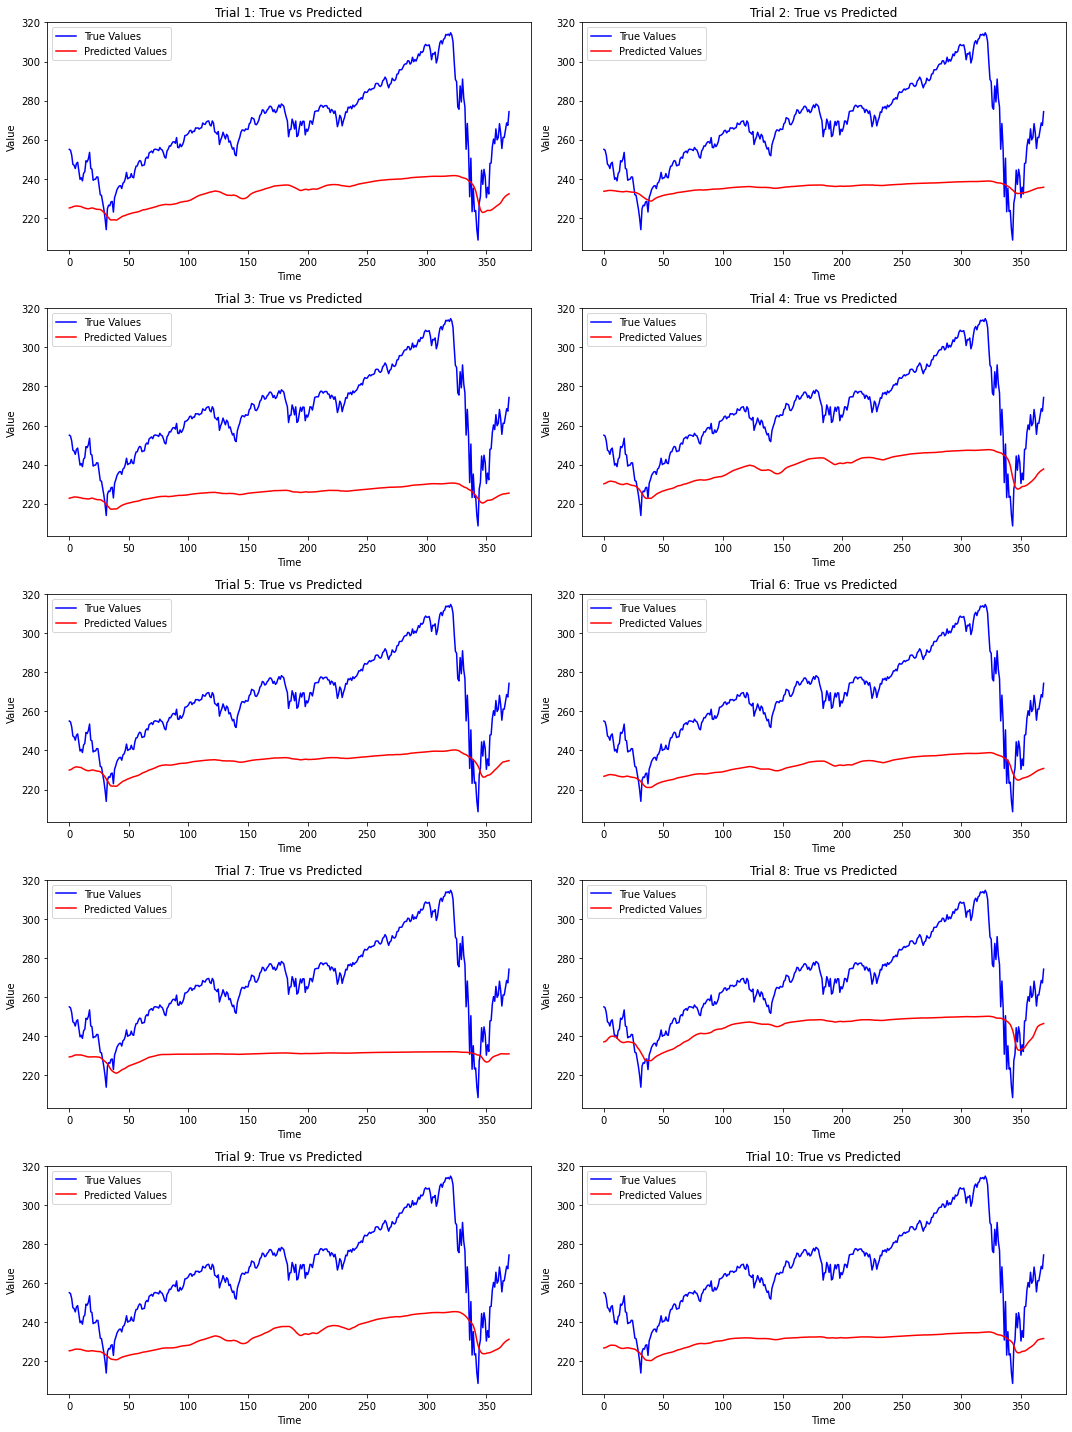


===== Final Results Across 10 Trials =====
Average Validation Loss: 300.2511 ± 105.0254
Average Test Loss: 1505.4478 ± 330.3055
Average MAE: 34.3392 ± 4.4065
Average Error Percentage: 12.39% ± 1.66%
Largest Error Percentage: 23.75% ± 1.94%


In [56]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0005
num_epochs = 500
patience = 30
num_trials = 10  # Number of runs

# Store results
results = {
    "val_loss": [],
    "test_loss": [],
    "mae": [],
    "avg_error_percent": [],
    "largest_error_percent": []
}

# Multi-plot setup
fig, axes = plt.subplots(5, 2, figsize=(15, 20))  # 5 rows, 2 columns

for trial in range(num_trials):
    print(f"\n===== Trial {trial+1} =====")
    
    # Initialize model
    model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)

    # Define loss and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with early stopping
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch = y_batch.unsqueeze(1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)

    test_loss /= len(test_loader.dataset)

    # Calculate Mean Absolute Error (MAE)
    test_mae = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            mae = torch.mean(torch.abs(outputs - y_batch))
            test_mae += mae.item() * X_batch.size(0)

    test_mae /= len(test_loader.dataset)

    # Compute error percentages
    X_seq_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_seq_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
    outputs = model(X_seq_tensor).cpu().detach().numpy()

    error = 0
    largest_error = 0
    less_than_actual = 0
    more_than_actual = 0

    for true, pred in zip(y_test, outputs):
        percent = abs(true - pred) / true
        if percent > largest_error:
            largest_error = percent
        error += percent
        if pred < true:
            less_than_actual += 1
        else:
            more_than_actual += 1

    avg_error = (error / len(y_test)).item()
    largest_error = largest_error.item()

    # Store results
    results["val_loss"].append(val_loss)
    results["test_loss"].append(test_loss)
    results["mae"].append(test_mae)
    results["avg_error_percent"].append(avg_error * 100)
    results["largest_error_percent"].append(largest_error * 100)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Average error percentage: {avg_error * 100:.2f}%")
    print(f"Largest error percentage: {largest_error * 100:.2f}%")

    # Plot predictions
    ax = axes[trial // 2, trial % 2]
    ax.plot(y_test, label='True Values', color='blue')
    ax.plot(outputs, label='Predicted Values', color='red')
    ax.set_title(f'Trial {trial + 1}: True vs Predicted')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()

# Display all subplots
plt.tight_layout()
plt.show()

# Print final average results
print("\n===== Final Results Across 10 Trials =====")
print(f"Average Validation Loss: {np.mean(results['val_loss']):.4f} ± {np.std(results['val_loss']):.4f}")
print(f"Average Test Loss: {np.mean(results['test_loss']):.4f} ± {np.std(results['test_loss']):.4f}")
print(f"Average MAE: {np.mean(results['mae']):.4f} ± {np.std(results['mae']):.4f}")
print(f"Average Error Percentage: {np.mean(results['avg_error_percent']):.2f}% ± {np.std(results['avg_error_percent']):.2f}%")
print(f"Largest Error Percentage: {np.mean(results['largest_error_percent']):.2f}% ± {np.std(results['largest_error_percent']):.2f}%")
